# [DRAFT] Hierarhical-Gaussian Filter

This notebook does not perform any becnhmark and simply runs the inference procedure and generates some nice plots for the thesis.

Note: This notebook is a draft, the real experiments are in the `notebooks/` folder

_Author: Dmitry Bagaev_

In [6]:
using DrWatson

In [7]:
@quickactivate "RxInferThesisExperiments"

In [16]:
using RxInferThesisExperiments, Turing, StaticArrays, Plots, PGFPlotsX, LaTeXStrings
using LinearAlgebra, StableRNGs, Random, BenchmarkTools, ColorSchemes, Dates, ProgressMeter

In [9]:
# For the thesis I use the `pgfplotsx` backend of the `Plots`, since it generates high-quiality plots
# But it is reallyyy slow, if some wants to generate plots faster uncoment the `gr()` line
# pgfplotsx()

# Use fast plotting backend
gr()

Plots.GRBackend()

In [219]:
# Include the model specification
# include(srcdir("models", "rxinfer", "hgf.jl"));

## Hierarhical Gaussian Filter environment

In [11]:
const environment = HGFEnvironment()

HGFEnvironment()

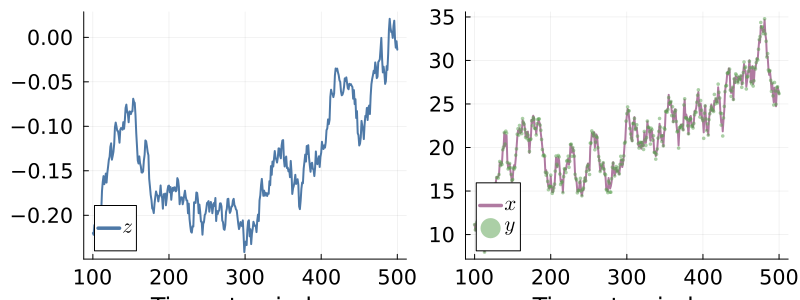

In [121]:
# For plotting purposes I only generate 250 points
T = 500
seed = 12345
rng = StableRNG(seed)

zstates, xstates, observations = rand(rng, environment, T);

# `plotting`range
prange = max((lastindex(observations) - 400), firstindex(observations)):1:lastindex(observations)
colors = ColorSchemes.tableau_10

# Some default settings for plotting
pfontsettings = (
    titlefontsize=18,
    guidefontsize=16,
    tickfontsize=14,
    legendfontsize=14,
    legend = :bottomleft,
    size = (400, 300)
)

p1 = plot(xlabel = "Time step index", ylabel = ""; pfontsettings...)
p1 = plot!(prange, zstates[prange], color = colors[1], linewidth = 2, label = L"z")

p2 = plot(xlabel = "Time step index", ylabel = ""; pfontsettings...)
p2 = plot!(p2, prange, xstates[prange], color = colors[7], linewidth = 2, label = L"x")
p2 = scatter!(p2, prange, observations[prange], color = colors[5], ms = 2, alpha = 0.5, msw = 0, label = L"y")

plot(p1, p2, layout = @layout([ a b ]), size = (800, 300))

In [115]:
Turing.setprogress!(false)

[ Info: [Turing]: progress logging is disabled globally
[ Info: [AdvancedVI]: global PROGRESS is set as false


false

In [68]:
@model function HGF(observation, zt_min_prior, xt_min_prior, z_std_prior, y_std_prior, kappa, omega)
    # Priors
    z_std ~ z_std_prior
    y_std ~ y_std_prior

    zt_min ~ zt_min_prior
    xt_min ~ xt_min_prior

    zt ~ Normal(zt_min, sqrt(inv(z_std)))
    xt ~ Normal(xt_min, sqrt(exp(kappa * zt + omega)))

    observation ~ Normal(xt, sqrt(inv(y_std)))
end

HGF (generic function with 4 methods)

In [69]:
function extract_params_for_next_step(chain)
    sumstats = Turing.summarize(chain, Turing.mean, Turing.std)
    
    xt_index = findnext(e -> e === :xt, sumstats.nt.parameters, 1)
    zt_index = findnext(e -> e === :zt, sumstats.nt.parameters, 1)
    z_std_index = findnext(e -> e === :z_std, sumstats.nt.parameters, 1)
    y_std_index = findnext(e -> e === :y_std, sumstats.nt.parameters, 1)
    
    z_std_mean = sumstats.nt.mean[z_std_index]
    z_std_var = abs2(sumstats.nt.std[z_std_index])
    y_std_mean = sumstats.nt.mean[y_std_index]
    y_std_var = abs2(sumstats.nt.std[y_std_index])
    
    return (
        xt_min_prior = Normal(sumstats.nt.mean[xt_index], sumstats.nt.std[xt_index]),
        zt_min_prior = Normal(sumstats.nt.mean[zt_index], sumstats.nt.std[zt_index]),
        z_std_prior  = Gamma(z_std_mean ^ 2 / z_std_var, z_std_var / z_std_mean),
        y_std_prior  = Gamma(y_std_mean ^ 2 / y_std_var, y_std_var / y_std_mean),
    )
end

extract_params_for_next_step (generic function with 1 method)

In [70]:
using Logging

In [118]:
function inference(observations, kappa, omega; nsamples = 1000, method = NUTS(), rng = StableRNG(42))
    # Disable turing's logger
    return with_logger(NullLogger()) do
        zt_min_prior = Normal(0.0, sqrt(5.0))
        xt_min_prior = Normal(0.0, sqrt(5.0))
        z_std_prior = Gamma(10000000.0, 0.001)
        y_std_prior = Gamma(100.0, 0.1)

        results = []

        @showprogress for observation in observations

            chain = sample(rng, HGF(observation, zt_min_prior, xt_min_prior, z_std_prior, y_std_prior, kappa, omega), method, nsamples);
            stats = extract_params_for_next_step(chain)

            zt_min_prior = stats[:zt_min_prior]
            xt_min_prior = stats[:xt_min_prior]
            z_std_prior = stats[:z_std_prior]
            y_std_prior = stats[:y_std_prior]

            push!(results, stats)
        end

        return results
    end
end
     

inference (generic function with 2 methods)

In [119]:
@time results = inference(observations, environment.kappa, environment.omega);

Progress: 100%|█████████████████████████████████████████| Time: 0:13:30


810.695521 seconds (5.93 G allocations: 833.834 GiB, 19.62% gc time, 0.01% compilation time)


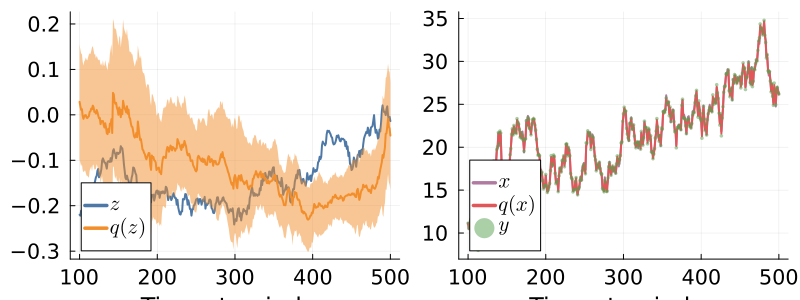

In [122]:
emz = mean.(getindex.(results, :zt_min_prior))
evz = std.(getindex.(results, :zt_min_prior))

emx = mean.(getindex.(results, :xt_min_prior))
evx = std.(getindex.(results, :xt_min_prior))

p1 = plot(xlabel = "Time step index", ylabel = ""; pfontsettings...)
p1 = plot!(p1, prange, zstates[prange], color = colors[1], linewidth = 2, label = L"z")
p1 = plot!(p1, prange, emz[prange], ribbon = evz[prange], color = colors[2], linewidth = 2, label = L"q(z)")

p2 = plot(xlabel = "Time step index", ylabel = ""; pfontsettings...)
p2 = plot!(p2, prange, xstates[prange], color = colors[7], linewidth = 2, label = L"x")
p2 = plot!(p2, prange, emx[prange], ribbon = evx[prange], color = colors[3], linewidth = 2, label = L"q(x)")
p2 = scatter!(p2, prange, observations[prange], color = colors[5], ms = 2, alpha = 0.5, msw = 0, label = L"y")

plot(p1, p2, layout = @layout([ a b ]), size = (800, 300))